In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import os
import pickle
import seaborn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from statistics import mean
from matplotlib.gridspec import GridSpec

from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std, normalize_0to1
from interpretability_methods.vanilla_gradients import VanillaGradients

class ColoredMNIST(torchvision.datasets.MNIST):
    """Extends MNIST dataset to include colored blocks."""

    def __init__(self, root, train = True, download = True, transform=None, correlation = False, digit_as_ground_truth = True):
        super().__init__(root, train, transform, None, download)
        self.digit_as_ground_truth = digit_as_ground_truth
        self.correlation = correlation
        self.colors = ['(230,25,75)', '(245,130,48)', '(255,225,25)', '(210, 245,60)', '(60,180,75)', '(70,240,240)', '(0,130,200)', '(145,30,180)', '(240,50,230)', '(0,0,128)']
        if (not self.correlation) and (not self.train):
            random.shuffle(self.colors)
        
    def __getitem__(self, index):
        """Returns the image, ground_truth mask, and label of the image."""
        image, target = super().__getitem__(index)
        # inverting black to white , white to black
        image = torchvision.transforms.functional.invert(image).numpy()
        ground_truth = self._create_ground_truth(image, self.digit_as_ground_truth)
        
        # adding color
        color_idx = target
        if (not self.correlation) and self.train:
            color_idx = random.randint(0,9)
        color = self.colors[color_idx].split(",")
        for c in range(3):
            c_color = color[c].replace('(','').replace(')','')
            for i in range(5):
                for j in range(5):
                    image[c][i][j] = bytes(c_color, 'utf-8')
        image = torch.from_numpy(image)
        normalize = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                    torchvision.transforms.ToTensor()])
        
        img_nr = normalize(image).float()
        ground_truth_nr = torch.squeeze(normalize(ground_truth), 0)
        return img_nr, ground_truth_nr, target
    
    def _create_ground_truth(self, image, digit_as_ground_truth):
        """Creates a binary groudn truth mask on the colored block."""
        ground_truth = torch.zeros((28, 28))
        if digit_as_ground_truth:
            non_black_pixels = np.where(
                (image[0, :, :] < 255) & 
                (image[1, :, :] < 255) & 
                (image[2, :, :] < 255)
            )
            ground_truth[non_black_pixels] = 1
        else:
            # ground truth as color block 
            for i in range(5):
                for j in range(5):
                    ground_truth[i][j] = 1
        return ground_truth

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [42]:
# training data without correlation between color and digit 
normal_train_data = ColoredMNIST('data', train = True, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = False)

# training data with correlation between color and digit 
corr_train_data = ColoredMNIST('data', train = True, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = True)

# test data without correlation between color and digit 
normal_test_data = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = False)

# test data with correlation between color and digit 
corr_test_data = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = True)

In [43]:
normal_train_loader = torch.utils.data.DataLoader(normal_train_data, batch_size=64, shuffle=True)
corr_train_loader = torch.utils.data.DataLoader(corr_train_data, batch_size=64, shuffle=True)


normal_test_loader = torch.utils.data.DataLoader(normal_test_data, batch_size=64, shuffle=False)
corr_test_loader = torch.utils.data.DataLoader(corr_test_data, batch_size=64, shuffle=False)

examples = enumerate(normal_train_loader)
batch_idx, (example_data, example_ground_truth, example_targets) = next(examples)


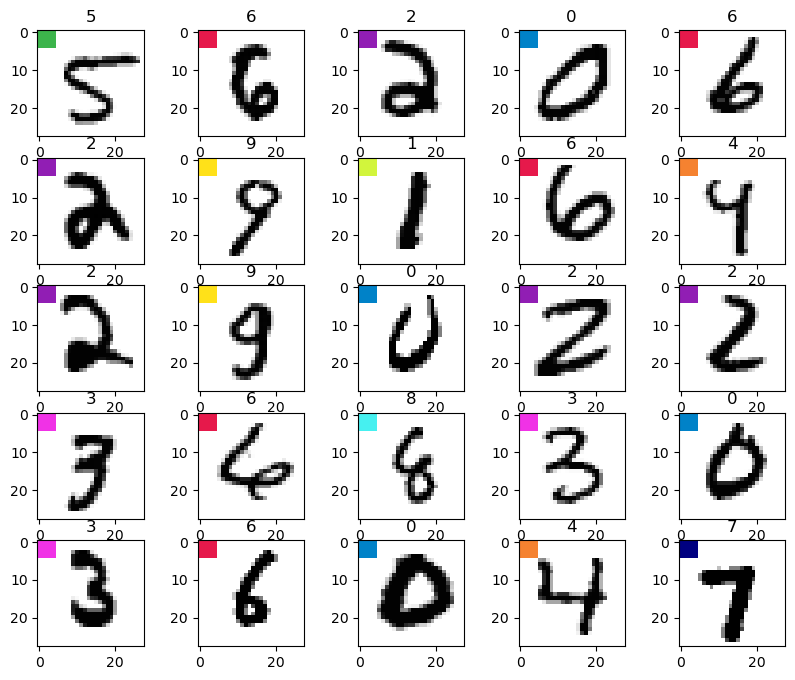

In [44]:
# examples of images 
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(normal_test_data), size=(1,)).item()
    img, ground_truth, label = normal_test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.permute(1,2,0))
plt.show()

In [6]:
# training datasets with the colored block as the ground truth

# without correlation
color_anno_normal = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = False, digit_as_ground_truth = False)

# with correlation 
color_anno_corr = ColoredMNIST('data', train = False, download = True, 
                          transform= torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=3),
                                                                     torchvision.transforms.PILToTensor()]),
                         correlation = True, digit_as_ground_truth = False)

In [7]:
color_anno_normal_loader = torch.utils.data.DataLoader(color_anno_normal, batch_size=64, shuffle=False)
color_anno_corr_loader = torch.utils.data.DataLoader(color_anno_corr, batch_size=64, shuffle=False)

In [8]:
def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [9]:
def train(epoch, device, model, optimizer, train_loader):
    model.train()
    for batch_idx, (data, ground_truth, target) in enumerate(tqdm(train_loader)):
        data, target = (data).to(device), target.to(device)
        ground_truth = ground_truth.numpy()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, 100. * batch_idx / len(train_loader), loss.item()))

In [18]:
def test(model, device, test_loader):
    model.eval()
    saliency_method = VanillaGradients(model)
    salient_pixel_count = 0
    correct = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    saliency_mean = 0
    saliency_std = 0
    with torch.no_grad():
        for batch_idx, (data, ground_truth, target) in enumerate(tqdm(test_loader)):
            data, target = (data).to(device), target.to(device)
            ground_truth = ground_truth.numpy()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            saliency = flatten(saliency_method.get_saliency(data))
            saliency_masks = binarize_std(saliency)
            
            # Compute Shared Interest scores
            for score in total_shared_interest_scores:
                shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
                total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))
            
            # iterate through all pixels 
            for i in range(saliency.shape[0]):
                saliency_batch = saliency[i]
                ground_truth_batch = ground_truth[i]
                pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
                point = ground_truth_batch[pixel[0], pixel[1]]

                # check if most salient feature is in ground truth 
                if point > 0:
                    salient_pixel_count += 1
    
    pointing_game = salient_pixel_count / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Accuracy: {}/{} ({:.0f}%)'.format(correct, len(test_loader.dataset), accuracy))
    print('IoU coverage: ' + str(mean(total_shared_interest_scores['iou_coverage'])))
    print('Pointing Game: ' + str(pointing_game))

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normal_model = Net().to(device)
optimizer = optim.SGD(normal_model.parameters(), lr=0.01, momentum=0.5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

n_epochs = 4
for epoch in range(n_epochs):
    train(epoch, device, normal_model, optimizer, normal_train_loader)
    scheduler.step()

test(normal_model, device, normal_test_loader)
test(normal_model, device, corr_test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:58<00:00,  7.91it/s]


Train Epoch: 0 [(100%)]	Loss: 0.262585


100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [02:01<00:00,  7.72it/s]


Train Epoch: 1 [(100%)]	Loss: 0.211852


100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:49<00:00,  8.59it/s]


Train Epoch: 2 [(100%)]	Loss: 0.078537


100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:40<00:00,  9.37it/s]


Train Epoch: 3 [(100%)]	Loss: 0.144822


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.55it/s]


Accuracy: 9807/10000 (98%)
IoU coverage: 0.2939412821522318
Pointing Gmae: 0.6978


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.50it/s]


Accuracy: 9806/10000 (98%)
IoU coverage: 0.29385390121859023
Pointing Gmae: 0.6985


In [17]:
corr_model = Net().to(device)
optimizer = optim.SGD(corr_model.parameters(), lr=0.01,momentum=0.5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

n_epochs = 4
for epoch in range(1, n_epochs + 1):
    train(epoch, device, corr_model, optimizer, corr_train_loader)
    scheduler.step()

test(corr_model, device, normal_test_loader)
test(corr_model, device, corr_test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [02:40<00:00,  5.86it/s]


Train Epoch: 1 [(100%)]	Loss: 0.514235


100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:56<00:00,  8.08it/s]


Train Epoch: 2 [(100%)]	Loss: 0.017834


100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [03:25<00:00,  4.56it/s]


Train Epoch: 3 [(100%)]	Loss: 0.049425


100%|██████████████████████████████████████████████████████████████████████████████████████| 938/938 [02:54<00:00,  5.38it/s]


Train Epoch: 4 [(100%)]	Loss: 0.046728


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.78it/s]


Accuracy: 4608/10000 (46%)
IoU coverage: 0.08658043606481623
Pointing Gmae: 0.048


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.98it/s]


Accuracy: 9964/10000 (100%)
IoU coverage: 0.15257778409037726
Pointing Gmae: 0.2142


In [19]:
test(normal_model, device, color_anno_normal_loader)
test(normal_model, device, color_anno_corr_loader)

test(corr_model, device, color_anno_normal_loader)
test(corr_model, device, color_anno_corr_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.09it/s]


Accuracy: 9802/10000 (98%)
IoU coverage: 0.001379023255143001
Pointing Game: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:30<00:00,  5.10it/s]


Accuracy: 9806/10000 (98%)
IoU coverage: 0.0017280056185448223
Pointing Game: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.89it/s]


Accuracy: 4553/10000 (46%)
IoU coverage: 0.22176393224090116
Pointing Game: 0.9371


100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:32<00:00,  4.90it/s]

Accuracy: 9964/10000 (100%)
IoU coverage: 0.14418293150900585
Pointing Game: 0.6129


In [66]:
def get_pointing_game(saliency, ground_truth):
    # iterate through all pixels 
    for s in range(saliency.shape[0]):
        saliency_batch = saliency[s]
        ground_truth_batch = ground_truth[s]
        pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
        point = ground_truth_batch[pixel[0], pixel[1]]

        # check if most salient feature is in ground truth 
        if point > 0:
            return True
    return False

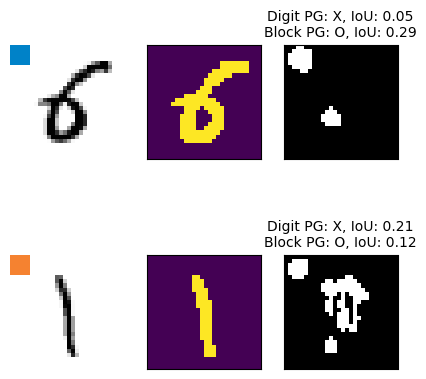

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(5, 5))
np.vectorize(ax_off)(ax)
fig_images = random.sample(range(10000), 2)

data = [corr_test_data[i] for i in fig_images]

saliency_method = VanillaGradients(corr_model)

for i, (data, ground_truth, target) in enumerate(data):
    data_ind = fig_images[i]
    masked_image = data * ground_truth
    ax[i, 0].imshow(data.permute(1,2,0))
    ax[i, 0].set(frame_on=False)
    ax[i, 1].imshow(ground_truth)
    
    data = data.to(device)

    saliency = flatten(saliency_method.get_saliency(data.unsqueeze(0)))
    saliency_masks = binarize_std(saliency)

    iou_coverage = shared_interest(ground_truth.unsqueeze(0), saliency_masks, score='iou_coverage')[0]
    pg = get_pointing_game(saliency, ground_truth.unsqueeze(0))
    
    saliency_image = np.expand_dims(saliency_masks, axis=3)
    ax[i, 2].imshow(saliency_image[0], cmap='gray')
    pg_string = "O" if pg else "X"
    
    ground_truth_block = torch.zeros((28, 28))
    for ii in range(5):
        for jj in range(5):
            ground_truth_block[ii][jj] = 1
    iou_coverage_block = shared_interest(ground_truth_block.unsqueeze(0), saliency_masks, score='iou_coverage')[0]
    pg_block = get_pointing_game(saliency, ground_truth_block.unsqueeze(0))
    pg_block_string = "O" if pg_block else "X"
    ax[i, 2].set_title("Digit PG: " + pg_string + ', IoU: ' + str(iou_coverage)[:4] + "\nBlock PG: " + pg_block_string + ', IoU: ' + str(iou_coverage_block)[:4], fontsize=10)


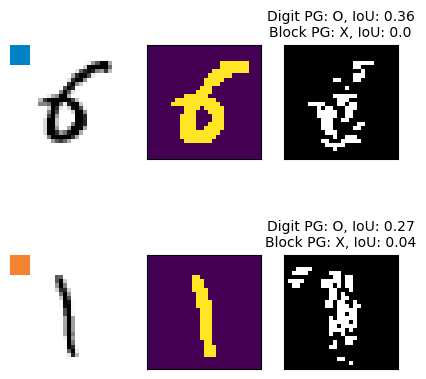

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(5, 5))
np.vectorize(ax_off)(ax)

saliency_method = VanillaGradients(normal_model)
pg = False 

data = [corr_test_data[i] for i in fig_images]

for i, (data, ground_truth, target) in enumerate(data):
    data_ind = fig_images[i]
    masked_image = data * ground_truth
    ax[i, 0].imshow(data.permute(1,2,0))
    ax[i, 0].set(frame_on=False)
    ax[i, 1].imshow(ground_truth)
    
    data = data.to(device)

    saliency = flatten(saliency_method.get_saliency(data.unsqueeze(0)))
    saliency_masks = binarize_std(saliency)

    iou_coverage = shared_interest(ground_truth.unsqueeze(0), saliency_masks, score='iou_coverage')[0]
    pg = get_pointing_game(saliency, ground_truth.unsqueeze(0))
    
    saliency_image = np.expand_dims(saliency_masks, axis=3)
    ax[i, 2].imshow(saliency_image[0], cmap='gray')
    pg_string = "O" if pg else "X"
    
    ground_truth_block = torch.zeros((28, 28))
    for ii in range(5):
        for jj in range(5):
            ground_truth_block[ii][jj] = 1
    iou_coverage_block = shared_interest(ground_truth_block.unsqueeze(0), saliency_masks, score='iou_coverage')[0]
    pg_block = get_pointing_game(saliency, ground_truth_block.unsqueeze(0))
    pg_block_string = "O" if pg_block else "X"
    ax[i, 2].set_title("Digit PG: " + pg_string + ', IoU: ' + str(iou_coverage)[:4] + "\nBlock PG: " + pg_block_string + ', IoU: ' + str(iou_coverage_block)[:4], fontsize=10)

In [21]:
def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )